## Exploração Inicial dos Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import plotly.express as px
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
import warnings
warnings.filterwarnings('ignore')

#Carregando os dados
df = pd.read_csv('dados/Adidas_Sales.csv')

#Visualização inicial
print("Primeiras linhas do dataset:")
print(df.head())
print("\nInformações do dataset:")
print(df.info())
print("\nEstatísticas descritivas:")
print(df.describe())
print("\nValores nulos por coluna:")
print(df.isnull().sum())
print("\nValores duplicados:", df.duplicated().sum())

#Verificando se há colunas repetidas
print("\nColunas com nomes repetidos:")
print([col for col in df.columns if df.columns.tolist().count(col) > 1])

Primeiras linhas do dataset:
   Unnamed: 0      id  price  category    size  availability        date  \
0       63575  HP9426   60.0  sneakers      36             0  07/01/2025   
1       63576  HP9426   60.0  sneakers  36 2/3             0  07/01/2025   
2       63577  HP9426   60.0  sneakers  37 1/3             0  07/01/2025   
3       63578  HP9426   60.0  sneakers      38             0  07/01/2025   
4       63579  HP9426   60.0  sneakers  38 2/3             1  07/01/2025   

  country_code    id.1                         name best_for_wear gender  \
0           DE  HP9426           Breaknet 2.0 Schuh          City      U   
1           DE  HQ4199     Ultraboost 1.0 Laufschuh          City      U   
2           DE  JQ2552  Adizero Boston 12 Laufschuh        Racing      U   
3           DE  JI1896                  NY 90 Schuh       Neutral      U   
4           DE  IE8976     Ultraboost 1.0 Laufschuh       Neutral      U   

                                           image_url domi

## Limpeza e Transformação dos Dados

In [2]:
#Removendo colunas repetidas e que não serão úteis
df_clean = df.drop(columns=['Unnamed: 0', 'id', 'country_code', 'shoe_metric', 'currency'])

#Renomeando as colunas para português
df_clean = df_clean.rename(columns={
    'name': 'product_name',
    'best_for_wear': 'best_for',
    'dominant_color': 'color_primary',
    'sub_color1': 'color_secondary',
    'sub_color2': 'color_tertiary'
})

#Tratando os valores nulos
df_clean['country_code'] = df['country_code'].fillna('Unknown')


#Criação das novas features
df_clean['size_numeric'] = df_clean['size'].str.extract('(\d+)').astype(float)
df_clean['has_stock'] = df_clean['availability'] > 0
df_clean['price_category'] = pd.cut(df_clean['price'], 
                                   bins=[0, 50, 100, 150, 200],
                                   labels=['Budget', 'Mid-range', 'Premium', 'Luxury'])

#Codificando as variáveis categóricas
le = LabelEncoder()
categorical_cols = ['category', 'gender', 'best_for', 'country_code']
for col in categorical_cols:
    df_clean[col + '_encoded'] = le.fit_transform(df_clean[col])

#Verificando os dados após a limpeza
print("\nDados após limpeza:")
print(df_clean.head())


Dados após limpeza:
   price  category    size  availability        date    id.1  \
0   60.0  sneakers      36             0  07/01/2025  HP9426   
1   60.0  sneakers  36 2/3             0  07/01/2025  HQ4199   
2   60.0  sneakers  37 1/3             0  07/01/2025  JQ2552   
3   60.0  sneakers      38             0  07/01/2025  JI1896   
4   60.0  sneakers  38 2/3             1  07/01/2025  IE8976   

                  product_name best_for gender  \
0           Breaknet 2.0 Schuh     City      U   
1     Ultraboost 1.0 Laufschuh     City      U   
2  Adizero Boston 12 Laufschuh   Racing      U   
3                  NY 90 Schuh  Neutral      U   
4     Ultraboost 1.0 Laufschuh  Neutral      U   

                                           image_url  ... color_tertiary  \
0  https://assets.adidas.com/images/w_600,f_auto,...  ...    Cloud White   
1  https://assets.adidas.com/images/w_600,f_auto,...  ...     Beam Green   
2  https://assets.adidas.com/images/w_600,f_auto,...  ...      Lu

## Análise Exploratória

#### Distribuição de Preço

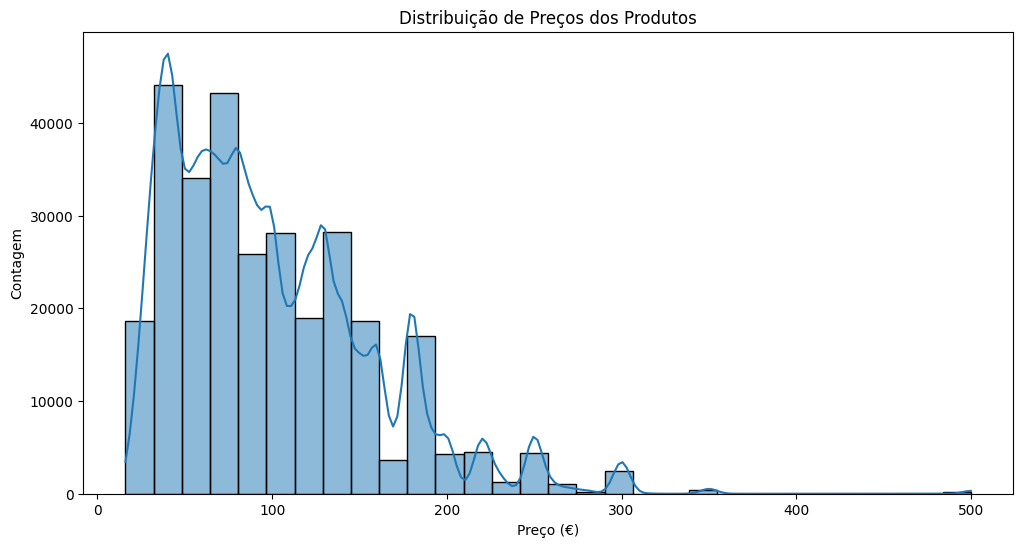


Estatísticas de preço:
count    299156.000000
mean         99.715583
std          58.325251
min          16.000000
25%          55.000000
50%          88.200000
75%         130.000000
max         500.000000
Name: price, dtype: float64


In [3]:
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['price'], bins=30, kde=True)
plt.title('Distribuição de Preços dos Produtos')
plt.xlabel('Preço (€)')
plt.ylabel('Contagem')
plt.show()

print("\nEstatísticas de preço:")
print(df_clean['price'].describe())

#### Disponibilidade por Categoria

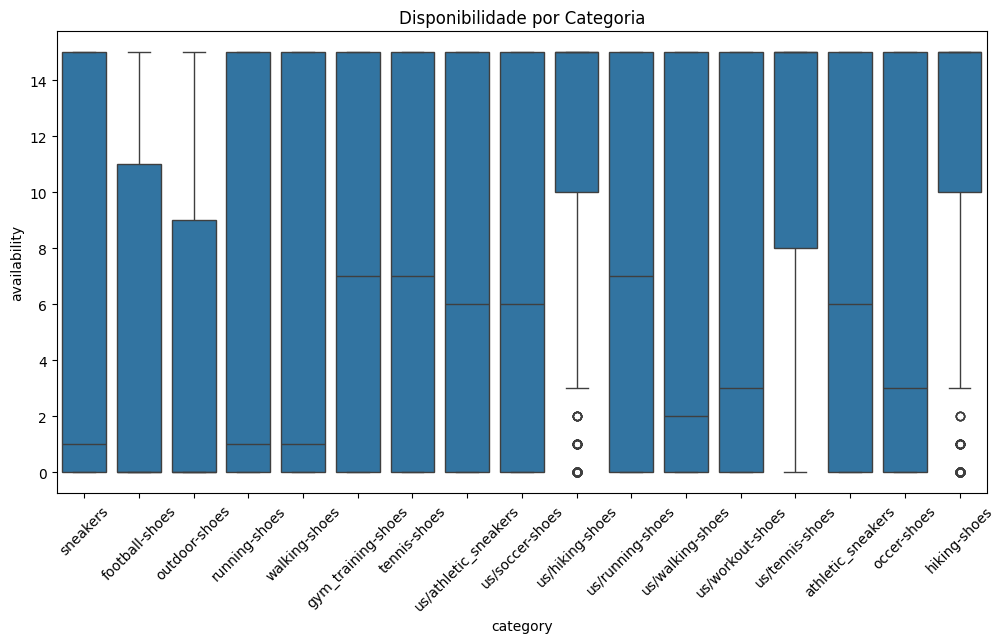


Taxa de produtos em estoque por categoria:
category
us/hiking-shoes         0.902665
hiking-shoes            0.885284
us/tennis-shoes         0.832117
gym_training-shoes      0.723170
tennis-shoes            0.711389
us/running-shoes        0.651951
us/athletic_sneakers    0.624387
us/soccer-shoes         0.623383
athletic_sneakers       0.608380
us/workout-shoes        0.594864
us/walking-shoes        0.583834
occer-shoes             0.578284
sneakers                0.533518
running-shoes           0.533266
walking-shoes           0.518222
outdoor-shoes           0.484204
football-shoes          0.377158
Name: has_stock, dtype: float64


In [4]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='category', y='availability', data=df_clean)
plt.title('Disponibilidade por Categoria')
plt.xticks(rotation=45)
plt.show()

# Taxa de produtos em estoque por categoria
stock_rate = df_clean.groupby('category')['has_stock'].mean().sort_values(ascending=False)
print("\nTaxa de produtos em estoque por categoria:")
print(stock_rate)

In [5]:
df_clean['has_stock']

0         False
1         False
2         False
3         False
4          True
          ...  
299151     True
299152    False
299153    False
299154     True
299155    False
Name: has_stock, Length: 299156, dtype: bool

#### Popularidade por Tamanho

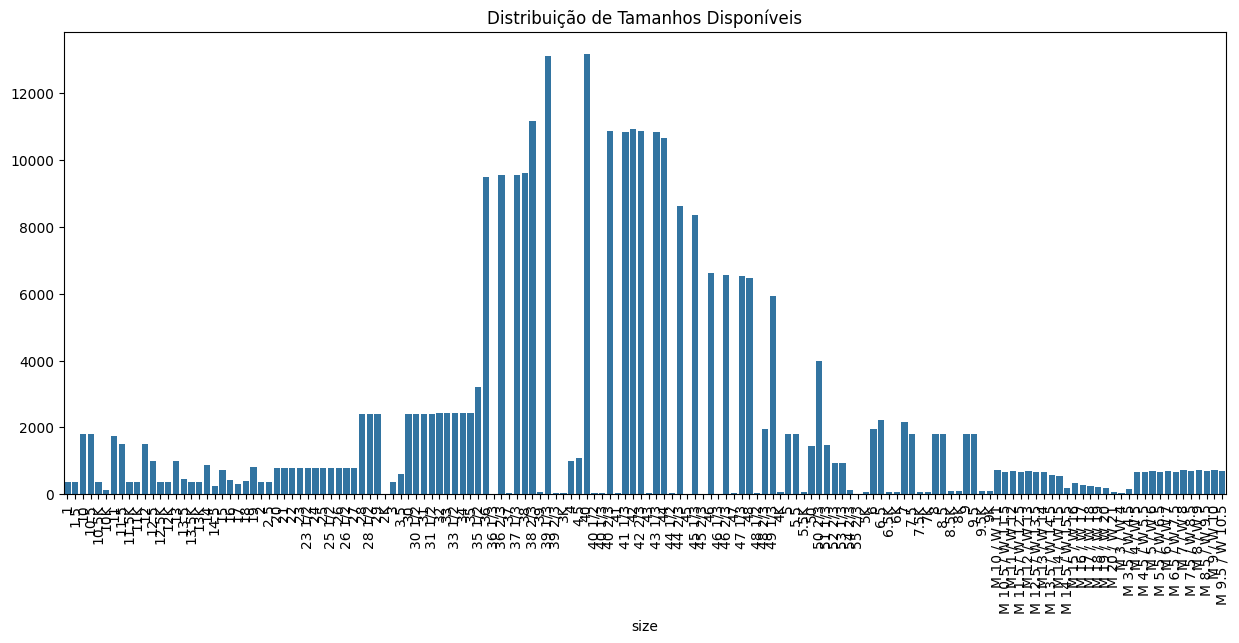


Tamanhos mais comuns em estoque:
size
40        7746
39 1/3    7419
41 1/3    7060
40 2/3    7016
42        6529
38 2/3    6068
38        5772
42 2/3    5745
37 1/3    5693
43 1/3    5422
Name: count, dtype: int64


In [6]:
plt.figure(figsize=(15, 6))
size_counts = df_clean['size'].value_counts().sort_index()
sns.barplot(x=size_counts.index, y=size_counts.values)
plt.title('Distribuição de Tamanhos Disponíveis')
plt.xticks(rotation=90)
plt.show()

# Tamanhos mais comuns em estoque
stock_by_size = df_clean[df_clean['has_stock']]['size'].value_counts().head(10)
print("\nTamanhos mais comuns em estoque:")
print(stock_by_size)

#### Correlações

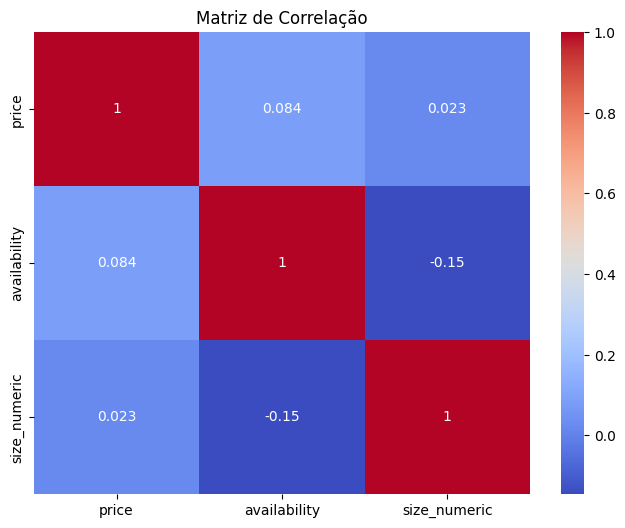

In [7]:
numeric_cols = ['price', 'availability', 'size_numeric']
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()

## Modelo Preditivo

In [8]:
#Preparando os dados para modelagem
features = ['size_numeric', 'availability', 'category_encoded', 'gender_encoded', 'best_for_encoded']
X = df_clean[features]
y = df_clean['price']

#Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Treinando o modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

#Avaliando o modelo
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nDesempenho do Modelo:")
print(f"MSE: {mse:.2f}")
print(f"R²: {r2:.2f}")

#Importância das features
feature_importance = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
print("\nImportância das Features:")
print(feature_importance)


Desempenho do Modelo:
MSE: 2435.52
R²: 0.28

Importância das Features:
category_encoded    0.456701
size_numeric        0.406773
availability        0.124449
best_for_encoded    0.007950
gender_encoded      0.004126
dtype: float64


In [9]:
df_clean[['gender']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299156 entries, 0 to 299155
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   gender  3302 non-null   object
dtypes: object(1)
memory usage: 2.3+ MB


## Dashboard em Dash

In [ ]:
#Criando o aplicativo em Dash
app = Dash(__name__)

#Obtendo as categorias e gêneros únicos, removendo valores nulos
unique_categories = [cat for cat in df_clean['category'].unique() if pd.notnull(cat)]
unique_genders = [gen for gen in df_clean['gender'].unique() if pd.notnull(gen)]

app.layout = html.Div([
    html.H1("Análise de Vendas da Adidas", style={'textAlign': 'center', 'color':'yellow'}),
    
    html.Div([
        dcc.Dropdown(
            id='category-selector',
            options=[{'label': cat, 'value': cat} for cat in unique_categories],
            value=unique_categories,  # Seleciona todos por padrão
            multi=True,
            placeholder="Selecione categorias"
        )
    ], style={'width': '48%', 'display': 'inline-block'}),
    
    html.Div([
        dcc.Dropdown(
            id='gender-selector',
            options=[{'label': gen, 'value': gen} for gen in unique_genders],
            value=unique_genders,  # Seleciona todos por padrão
            multi=True,
            placeholder="Selecione gêneros"
        )
    ], style={'width': '48%', 'float': 'right', 'display': 'inline-block'}),
    
    dcc.Graph(id='price-distribution'),
    
    dcc.Graph(id='availability-plot'),
    
    dcc.Graph(id='size-distribution'),
    
    html.Div([
        dcc.Graph(id='price-vs-size'),
        dcc.Graph(id='stock-rate')
    ], style={'display': 'flex'})
])

@app.callback(
    [Output('price-distribution', 'figure'),
     Output('availability-plot', 'figure'),
     Output('size-distribution', 'figure'),
     Output('price-vs-size', 'figure'),
     Output('stock-rate', 'figure')],
    [Input('category-selector', 'value'),
     Input('gender-selector', 'value')]
)
def update_graphs(selected_categories, selected_genders):
    #Filtrando o DataFrame baseado nas seleções
    if not selected_categories:  #Se nenhuma categoria for selecionada, mostra todas
        selected_categories = unique_categories
    if not selected_genders:  #Se nenhum gênero for selecionado, mostra todos
        selected_genders = unique_genders
    
    filtered_df = df_clean[
        (df_clean['category'].isin(selected_categories)) & 
        (df_clean['gender'].isin(selected_genders))
    ]
    
    #Gráfico de distribuição de preços
    price_fig = px.histogram(
        filtered_df, x='price', nbins=30, 
        title='Distribuição de Preços',
        labels={'price': 'Preço (€)'}
    )
    
    #Gráfico de disponibilidade
    avail_fig = px.box(
        filtered_df, x='category', y='availability',
        title='Disponibilidade por Categoria',
        labels={'availability': 'Unidades Disponíveis', 'category': 'Categoria'}
    )
    
    #Gráfico de distribuição de tamanhos
    size_counts = filtered_df['size'].value_counts().reset_index()
    size_counts.columns = ['size', 'count']
    size_fig = px.bar(
        size_counts, x='size', y='count',
        title='Distribuição de Tamanhos',
        labels={'size': 'Tamanho', 'count': 'Contagem'}
    )
    
    #Gráfico de preço vs tamanho
    price_size_fig = px.scatter(
        filtered_df, x='size_numeric', y='price', color='category',
        title='Preço vs Tamanho',
        labels={'size_numeric': 'Tamanho Numérico', 'price': 'Preço (€)'}
    )
    
    #Taxa de estoque por categoria
    stock_rate = filtered_df.groupby('category')['has_stock'].mean().reset_index()
    stock_fig = px.bar(
        stock_rate, x='category', y='has_stock',
        title='Taxa de Produtos em Estoque por Categoria',
        labels={'has_stock': 'Taxa de Estoque', 'category': 'Categoria'}
    )
    
    return price_fig, avail_fig, size_fig, price_size_fig, stock_fig

if __name__ == '__main__':
    app.run_server(debug=True)